## Summary of different models:

    S. No |  Model                |    Training Data    |    Test Data
    
    1.    |  SVM Regressor        |    0.9648315        |    0.9562091
    2.    |  Linear Regression    |    0.9726291        |    0.9660127
    3.    |  Decision Tree        |    0.9950196        |    0.9675000
    4.    |  ADA Boost Regressor  |    0.9757537        |    0.9714642
    5.    |  Random Forest        |    0.9899566        |    0.9717131
    6.    |  Neural Network       |    0.9811626        |    0.9746999
    7.    |  GB Regressor         |    0.9998022        |    0.9792305
    8.    |  LightGBM Regressor   |    0.9928817        |    0.9806520
    9.    |  XGBoost Regressor    |    0.9977835        |    0.9822711

## Feature importance derived from various models:

    S. No |  Model               |  Rank 1  |  Rank 2  |  Rank 3  |  Rank 4  |  Rank 5 
    
    1.    |  Decision Tree       |  Dt      |  Cr      |  TT      |  NT      |  P       
    2.    |  Random Forest       |  QmT     |  Ct      |  Cr      |  NT      |  Tt
    3.    |  LightGBM Regressor  |  C       |  TT      |  Cr      |  Mn      |  S
    4.    |  XGBoost Regressor   |  TT      |  Mn      |  C       |  Cr      |  P
    5.    |  ADA Boost Regressor |  TT      |  Cr      |  Ct      |  C       |  Tt

## Importing the necessary libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
import tensorflow as tf
import xgboost as xgb
from sklearn.svm import SVR
from tensorflow import keras
from tensorflow.keras import layers
import keras
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)
Using TensorFlow backend.


In [4]:
cd "/Users/chiragbhattad/Downloads/DDP/Fatigue Strength dataset"

/Users/chiragbhattad/Downloads/DDP/Fatigue Strength dataset


### Importing the dataset using pandas library and dropping the 'SI. No.' column

In [5]:
data = pd.read_excel("fatigue.xlsx")
data.drop(['Sl. No.'],axis=1, inplace=True)

### Data correlation visualized using heat map

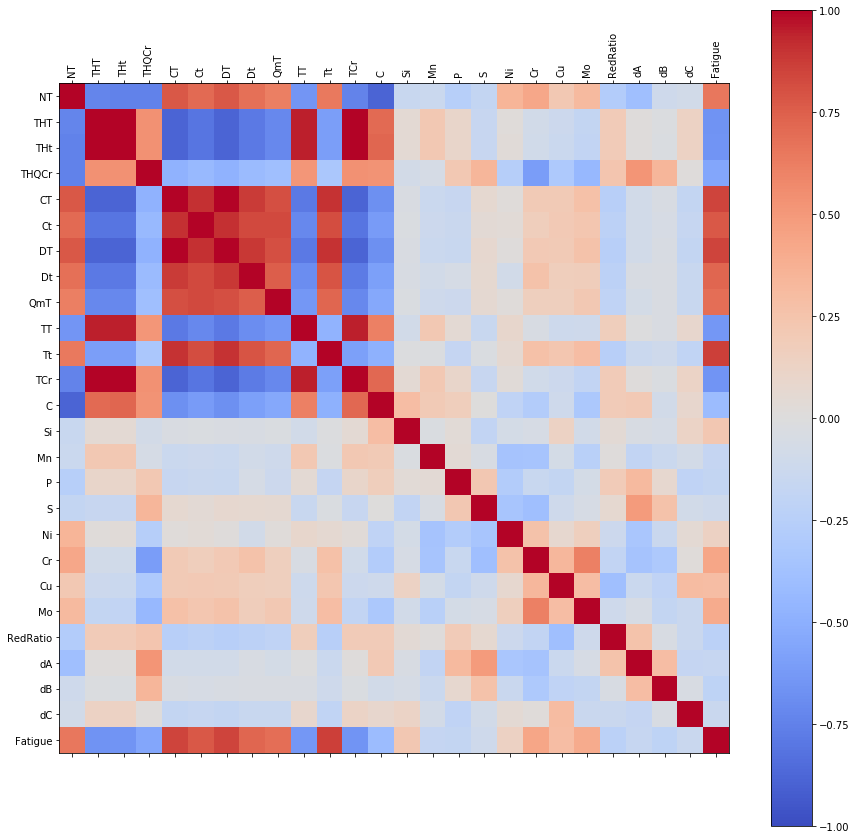

In [6]:
corr = data.corr()
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()

### Splitting of the dataset into feature variable and target variable

In [7]:
feature = data.columns[:-1]
target = data.columns[-1]
X = data[feature]
y = data[target]

## Feature Ranking

### 1. Univariate Selection

    Univariate analysis examines the relationship of each feature with the target variable individually. This can be measured using teh Pearson coefficient, Maximal Information Coefficient or distance correlation.

    1. Pearson Coefficient: It is a measure of the correlation between two variables. It has a value between -1 and +1 with -1 being perfect negative correlation and +1 being perfect positive correlation. Pearson correlation of 0 does not mean the variables are independent.
                        ρ(x,y) = cov(X,Y)/σxσy

    2. Maximal Information Coefficient: It measures the mutual dependance between two variables. MIC gives a score in bits which is not normalized. It is also inconvenient to compute it for continuous variables  in general the variables need to be discretized by binning, but the mutual information score can be quite sensitive to bin selection.
                        I(X,Y) = ∑∑p(x,y)log[p(x,y)/p(x)p(y)]
    
    3. Distance correlation: It is a measure of dependence between two paired random vectors of arbitrary, not necessarily equal, dimension. Thus, distance correlation measures both linear and nonlinear association between two random variables or random vectors.

In [8]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [9]:
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X, y)
np.set_printoptions(precision=3)
print(fit.scores_)

[2.968e+02 4.634e+04 1.770e+03 2.135e+03 2.686e+05 1.731e+05 2.515e+05
 2.212e+04 4.633e+03 2.150e+04 3.090e+03 1.365e+03 8.907e+00 8.738e+01
 2.651e+01 4.692e-01 7.326e-01 3.509e+02 1.077e+02 1.037e+01 3.372e+01
 7.862e+04 5.481e+00 5.962e+00 3.641e+00]


In [10]:
# Selected Features:
features = fit.transform(X)
print(features[0:5,:])

[[  30.    0.   30.  825.]
 [  30.    0.   30.  610.]
 [  30.    0.   30. 1270.]
 [  30.    0.   30. 1740.]
 [  30.    0.   30.  825.]]


### 2. Recursive Feature Elimination

    Given an external estimator that assigns weights to features, the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

In [12]:
model = LogisticRegression()
rfe = RFE(model, 10)

fit = rfe.fit(X, y)

print("Num Features: %d"% fit.n_features_)
print("Selected Features: %s"% fit.support_)
print("Feature Ranking: %s"% fit.ranking_)

Num Features: 10
Selected Features: [False False  True  True  True False  True False  True False  True False
 False  True  True False False  True  True False False False False False
 False]
Feature Ranking: [ 3  2  1  1  1 10  1  5  1  6  1  4  9  1  1 16 15  1  1  8  7 11 12 14
 13]


## Principal Component Analysis

    Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. This transformation is defined in such a way that the first principal component has the largest possible variance, and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components. The resulting vectors are an uncorrelated orthogonal basis set. PCA is sensitive to the relative scaling of the original variables.

In [13]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [14]:
pca = PCA(n_components=2, random_state=1)
principal_components = pca.fit_transform(X)

Text(0.5,1,'Distribution of training dataset after PCA')

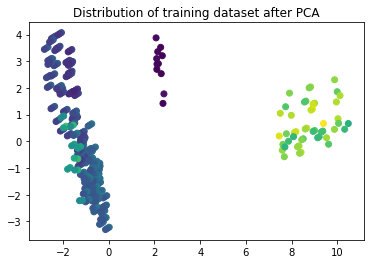

In [15]:
plt.scatter(principal_components[:,0],principal_components[:,1], c = y)
plt.title("Distribution of training dataset after PCA")

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## SVM regressor

    Support Vector Machine can also be used as a regression method, maintaining all the main features that characterize the algorithm (maximal margin). The Support Vector Regression (SVR) uses the same principles as the SVM for classification, with only a few minor differences. First of all, because output is a real number it becomes very difficult to predict the information at hand, which has infinite possibilities. In the case of regression, a margin of tolerance (epsilon) is set in approximation to the SVM which would have already requested from the problem. The main idea is the same: to minimize error, individualizing the hyperplane which maximizes the margin, keeping in mind that part of the error is tolerated.

    Hyperplane is the line that will will help us predict the continuous value or target value. There are two lines other than Hyper Plane which creates a margin. These are the boundary lines. Support vectors can be on the Boundary lines or outside it. 

In [28]:
svreg = SVR(kernel='linear', verbose=1, C=15)
svreg.fit(X_train, y_train)
SVRtrain = r2_score(y_train, svreg.predict(X_train))
print("\nSVM Regressor Train data:", SVRtrain)

[LibSVM]
SVM Regressor Train data: 0.9648315352686063


In [29]:
Y_pred_3 = svreg.predict(X_test)
SVRerror = r2_score(y_test, Y_pred_3)
print("SVM Regressor Test data:", SVRerror)

SVM Regressor Test data: 0.9562091423070158


Visualizing the predictions made by the SVM Regressor algorithm and comparing it with the actual data points present in the training and testing dataset.

Text(0.5,1,'TRAIN DATA: Blue -> Prediction | Orange -> Actual')

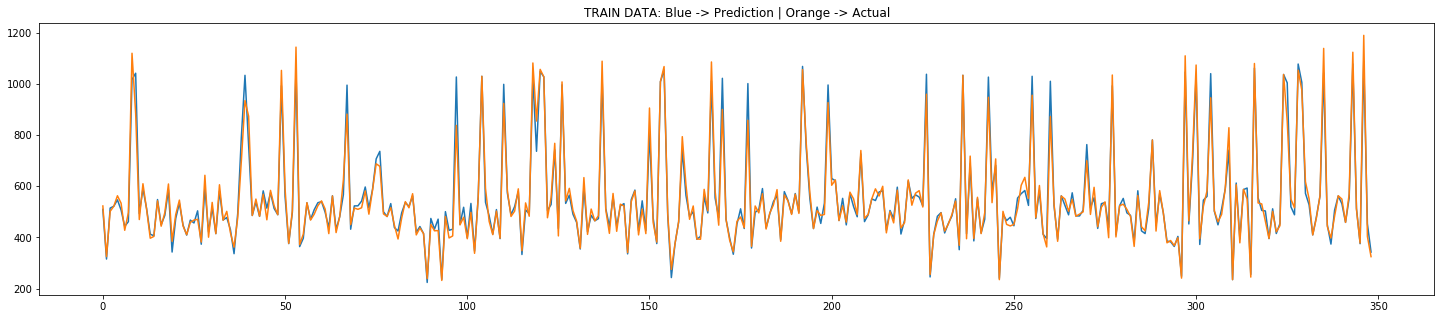

In [30]:
train_pred_3 = svreg.predict(X_train)
plt.figure(figsize=(25,5))
plt.plot(range(349), train_pred_3)
plt.plot(range(349), y_train)
plt.title('TRAIN DATA: Blue -> Prediction | Orange -> Actual')

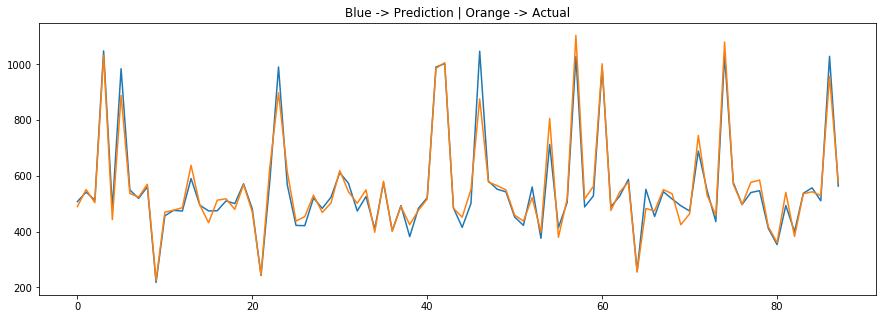

In [31]:
plt.figure(figsize=(15,5))
plt.plot(range(88), Y_pred_3)
plt.plot(range(88), y_test)
plt.title('Blue -> Prediction | Orange -> Actual')
plt.show()

## Linear Regression

    Simple linear regression is useful for finding relationship between two continuous variables. One is predictor or independent variable and other is response or dependent variable. It looks for statistical relationship but not deterministic relationship. Relationship between two variables is said to be deterministic if one variable can be accurately expressed by the other. Statistical relationship is not accurate in determining relationship between two variables.

    The core idea is to obtain a line that best fits the data. The best fit line is the one for which total prediction error (all data points) are as small as possible. Error is the distance between the point to the regression line.

In [17]:
linreg = LinearRegression().fit(X_train,y_train)
linregression = linreg.score(X,y)
LTerror = r2_score(y_train, linreg.predict(X_train))
print("Linear Regression Training data:", LTerror)

Linear Regression Training data: 0.9726290837671628


In [18]:
Y_pred_1 = linreg.predict(X_test)
linerror = r2_score(y_test, Y_pred_1)
print("Linear Regression Test data:", linerror)

Linear Regression Test data: 0.9660127116942134


Visualizing the predictions made by the Linear regression algorithm and comparing it with the actual data points present in the training and testing dataset.

Text(0.5,1,'TRAIN DATA: Blue -> Prediction | Orange -> Actual')

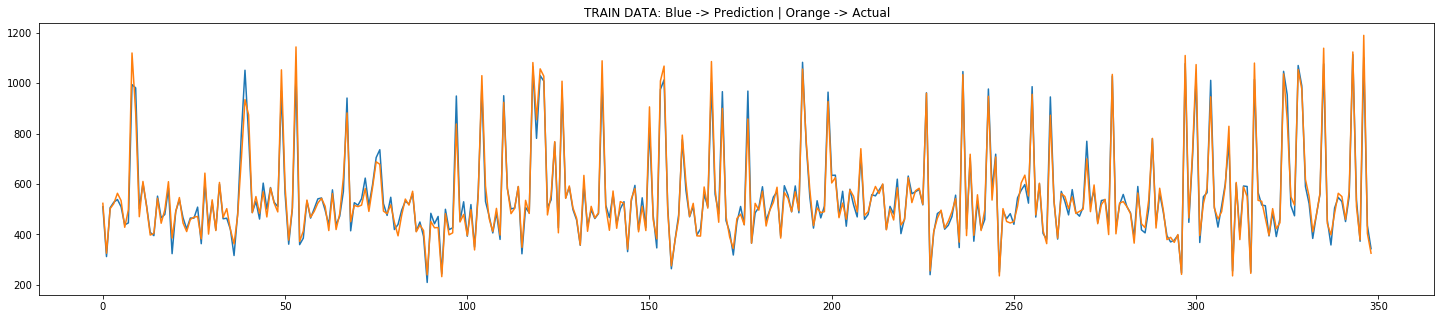

In [19]:
train_pred_1 = linreg.predict(X_train)
plt.figure(figsize=(25,5))
plt.plot(range(349), train_pred_1)
plt.plot(range(349), y_train)
plt.title('TRAIN DATA: Blue -> Prediction | Orange -> Actual')

Text(0.5,1,'TEST DATA: Blue -> Prediction | Orange -> Actual')

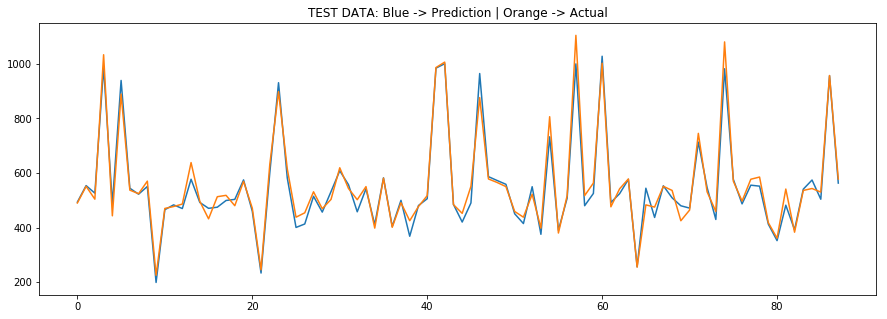

In [20]:
plt.figure(figsize=(15,5))
plt.plot(range(88), Y_pred_1)
plt.plot(range(88), y_test)
plt.title('TEST DATA: Blue -> Prediction | Orange -> Actual')

## Decision Tree Regressor

    Decision Trees are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. Decision Trees are Simple to understand and to interpret They require very little data preparation.  Thus it can be classified as a white box model i.e., if a given situation is observable in a model, the explanation for the condition is easily explained by boolean logic.

    A Decision tree regreesor breaks down the dataset into smaller and smaller subsets while at the same time an associated decision tree is incrementally developed. The final result is a tree with decision nodes and leaf nodes. A decision node (e.g., Outlook) has two or more branches (e.g., Sunny, Overcast and Rainy), each representing values for the attribute tested. Leaf node (e.g., Hours Played) represents a decision on the numerical target. The topmost decision node in a tree which corresponds to the best predictor called root node. Decision trees can handle both categorical and numerical data. 

In [32]:
dtregr = DecisionTreeRegressor(max_depth=8, random_state=1)
dtregr.fit(X_train, y_train)
DTRtrain = r2_score(y_train, dtregr.predict(X_train))
print("Decision Tree Train data:", DTRtrain)

Decision Tree Train data: 0.9950196228271856


In [33]:
Y_pred_4 = dtregr.predict(X_test)
DTRerror = r2_score(y_test, Y_pred_4)
print("Decision Tree Test data:", DTRerror)

Decision Tree Test data: 0.9675000404942423


Visualizing the predictions made by the Decision Tree Regressor and comparing it with the actual data points present in the training and testing dataset.

Text(0.5,1,'TRAIN DATA: Blue -> Prediction | Orange -> Actual')

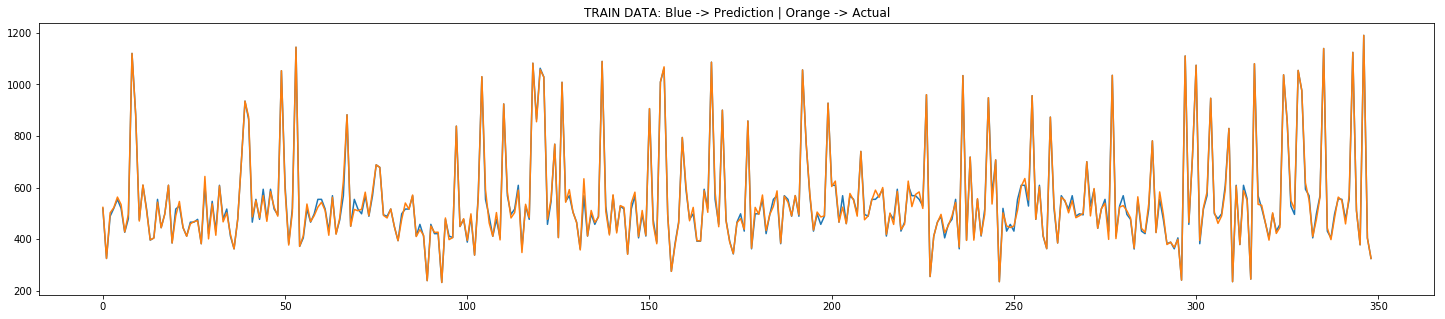

In [34]:
train_pred_4 = dtregr.predict(X_train)
plt.figure(figsize=(25,5))
plt.plot(range(349), train_pred_4)
plt.plot(range(349), y_train)
plt.title('TRAIN DATA: Blue -> Prediction | Orange -> Actual')

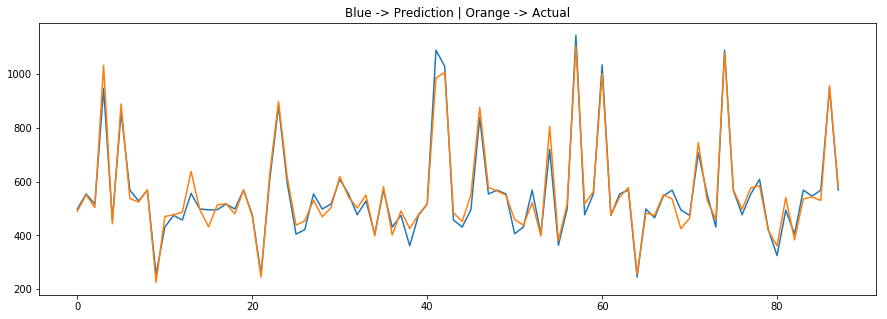

In [35]:
plt.figure(figsize=(15,5))
plt.plot(range(88), Y_pred_4)
plt.plot(range(88), y_test)
plt.title('Blue -> Prediction | Orange -> Actual')
plt.show()

In [36]:
independent_features = data[feature]
importance_dt = dict(zip(independent_features.columns, dtregr.feature_importances_))
importance_dt

{'NT': 0.020036150493788374,
 'THT': 0.0,
 'THt': 0.0,
 'THQCr': 0.0,
 'CT': 0.0,
 'Ct': 0.0009337561340215294,
 'DT': 2.9724487110995646e-05,
 'Dt': 0.722030040638826,
 'QmT': 0.0001653483465910396,
 'TT': 0.10048572036774055,
 'Tt': 0.0,
 'TCr': 0.0,
 'C': 0.0110600331656025,
 'Si': 0.0025839458232419952,
 'Mn': 0.004094362004372058,
 'P': 0.017159766267312665,
 'S': 0.0006246288109216496,
 'Ni': 0.00031360708344815825,
 'Cr': 0.11176234111712824,
 'Cu': 0.001220125765014316,
 'Mo': 0.0019434685147945955,
 'RedRatio': 0.0006644215817043756,
 'dA': 0.004505473544751429,
 'dB': 0.00035979691752236555,
 'dC': 2.7288936107310246e-05}

## Neural Network

    An Artificial Neural Network (ANN) is an information processing paradigm that is inspired by the way biological nervous systems, such as the brain, process information. The key element of this paradigm is the novel structure of the information processing system. It is composed of a large number of highly interconnected processing elements working in unison to solve specific problems. ANNs, like people, learn by example. An ANN is configured for a specific application, such as pattern recognition or data classification, through a learning process. Learning in biological systems involves adjustments to the synaptic connections that exist between the neurones. This is true of ANNs as well.

    Description of the ANN:

    Layer (type)      |          Output Shape |            Param  

    dense_1 (Dense)   |          (None, 512)  |            13312     
    dense_2 (Dense)   |          (None, 256)  |            131328    
    dense_3 (Dense)   |          (None, 128)  |            32896     
    dense_4 (Dense)   |          (None, 64)   |            8256      
    dense_5 (Dense)   |          (None, 01)   |            65        


    Total params: 185,857

    Trainable params: 185,857

    Non-trainable params: 0

In [21]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(512, kernel_initializer='normal',input_dim = 25, activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(128, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(64, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               13312     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 185,857
Trainable params: 185,857
Non-trainable params: 0
_________________________________________________________________


In [22]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [23]:
NN_model.fit(X_train, y_train, epochs=50, validation_split = 0.2, callbacks=callbacks_list)

Train on 279 samples, validate on 70 samples
Epoch 1/50
279/279 [==============================] - 1s 2ms/step - loss: 545.7304 - mean_absolute_error: 545.7304 - val_loss: 573.8336 - val_mean_absolute_error: 573.8336

Epoch 00001: val_loss improved from inf to 573.83364, saving model to Weights-001--573.83364.hdf5
Epoch 2/50
279/279 [==============================] - 0s 290us/step - loss: 542.4685 - mean_absolute_error: 542.4685 - val_loss: 564.7517 - val_mean_absolute_error: 564.7517

Epoch 00002: val_loss improved from 573.83364 to 564.75172, saving model to Weights-002--564.75172.hdf5
Epoch 3/50
279/279 [==============================] - 0s 232us/step - loss: 522.9536 - mean_absolute_error: 522.9536 - val_loss: 518.8662 - val_mean_absolute_error: 518.8662

Epoch 00003: val_loss improved from 564.75172 to 518.86616, saving model to Weights-003--518.86616.hdf5
Epoch 4/50
279/279 [==============================] - 0s 196us/step - loss: 434.1980 - mean_absolute_error: 434.1980 - val_los

279/279 [==============================] - 0s 202us/step - loss: 19.0158 - mean_absolute_error: 19.0158 - val_loss: 30.6291 - val_mean_absolute_error: 30.6291

Epoch 00033: val_loss did not improve from 27.81891
Epoch 34/50
279/279 [==============================] - 0s 176us/step - loss: 19.5491 - mean_absolute_error: 19.5491 - val_loss: 30.7299 - val_mean_absolute_error: 30.7299

Epoch 00034: val_loss did not improve from 27.81891
Epoch 35/50
279/279 [==============================] - 0s 173us/step - loss: 22.3261 - mean_absolute_error: 22.3261 - val_loss: 31.4911 - val_mean_absolute_error: 31.4911

Epoch 00035: val_loss did not improve from 27.81891
Epoch 36/50
279/279 [==============================] - 0s 166us/step - loss: 19.5133 - mean_absolute_error: 19.5133 - val_loss: 27.1102 - val_mean_absolute_error: 27.1102

Epoch 00036: val_loss improved from 27.81891 to 27.11023, saving model to Weights-036--27.11023.hdf5
Epoch 37/50
279/279 [==============================] - 0s 205us/ste

In [24]:
NNerror = r2_score(y_train, NN_model.predict(X_train))
print("Neural Network Training data:", NNerror)

Neural Network Training data: 0.9765007352207999


In [25]:
Y_pred_2 = NN_model.predict(X_test)
nnerror = r2_score(y_test, Y_pred_2)
print("Neural Network Test data:", nnerror)

Neural Network Test data: 0.9755614187034225


Visualizing the predictions made by the Artificial Neural Network and comparing it with the actual data points present in the training and testing dataset.

Text(0.5,1,'TRAIN DATA: Blue -> Prediction | Orange -> Actual')

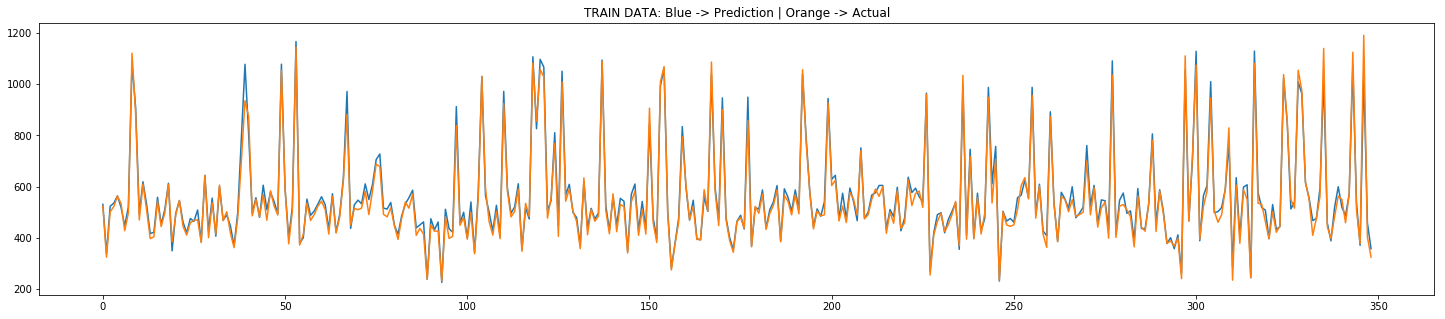

In [26]:
train_pred_2 = NN_model.predict(X_train)
plt.figure(figsize=(25,5))
plt.plot(range(349), train_pred_2)
plt.plot(range(349), y_train)
plt.title('TRAIN DATA: Blue -> Prediction | Orange -> Actual')

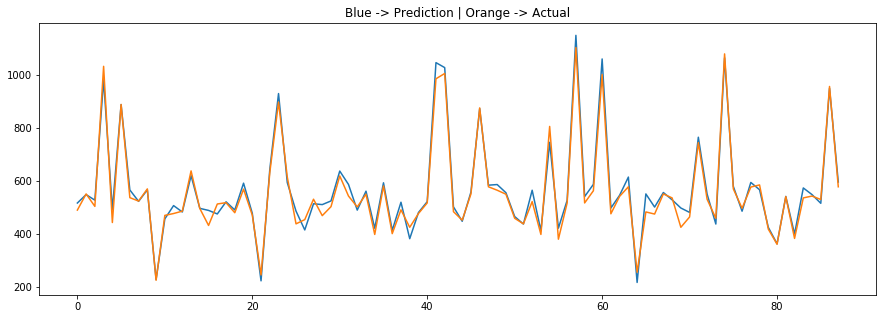

In [27]:
Y_pred_2 = NN_model.predict(X_test)
plt.figure(figsize=(15,5))
plt.plot(range(88), Y_pred_2)
plt.plot(range(88), y_test)
plt.title('Blue -> Prediction | Orange -> Actual')
plt.show()

Using the attribute 'feature_importances_' to rank the importance of each feature with respect to the target variable.

## RandomForestRegressor

    The random forest model is a type of additive model that makes predictions by combining decisions from a sequence of base models. More formally we can write this class of models as:

                                        g(x)=f0(x)+f1(x)+f2(x)+...

    where the final model g is the sum of simple base models fi. Here, each base classifier is a simple decision tree. This broad technique of using multiple models to obtain better predictive performance is called model ensembling. In random forests, all the base models are constructed independently using a different subsample of the data. The subsample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True

    The random forest model is very good at handling tabular data with numerical features, or categorical features with fewer than hundreds of categories. Unlike linear models, random forests are able to capture non-linear interaction between the features and the target. When dealing with sparse input data (e.g. categorical features with large dimension), we can either pre-process the sparse features to generate numerical statistics, or switch to a linear model, which is better suited for such scenarios.

In [37]:
rfregr = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_depth=6, verbose=True, random_state=1, oob_score=True)
rfregr.fit(X_train, y_train)
rfrtrain = r2_score(y_train, rfregr.predict(X_train))
print("Random Forest Train data:", rfrtrain)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s


Random Forest Train data: 0.9899565761671194


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [38]:
Y_pred_5 = rfregr.predict(X_test)
RFRerror = r2_score(y_test, Y_pred_5)
print("Random Forest Test data:", RFRerror)

Random Forest Test data: 0.9717131407054426


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


Visualizing the predictions made by the Random Forest Regressor and comparing it with the actual data points present in the training and testing dataset.

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


Text(0.5,1,'TRAIN DATA: Blue -> Prediction | Orange -> Actual')

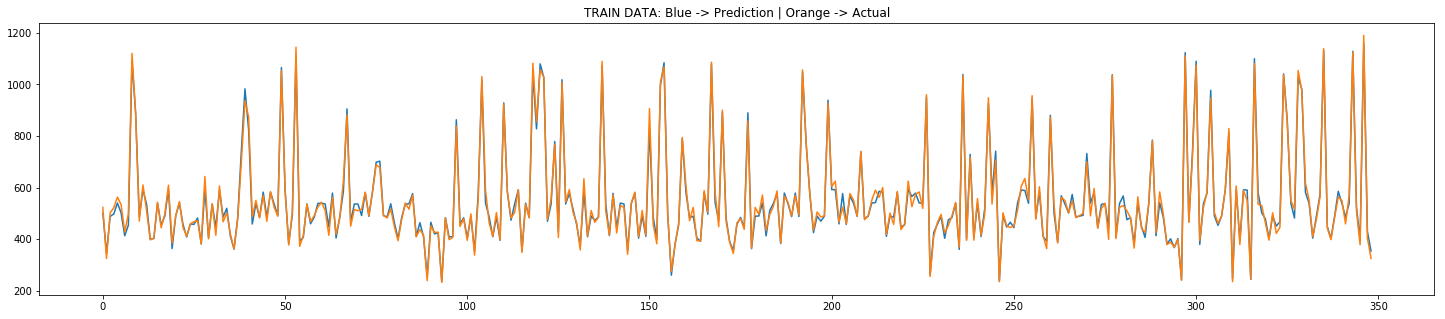

In [39]:
train_pred_5 = rfregr.predict(X_train)
plt.figure(figsize=(25,5))
plt.plot(range(349), train_pred_5)
plt.plot(range(349), y_train)
plt.title('TRAIN DATA: Blue -> Prediction | Orange -> Actual')

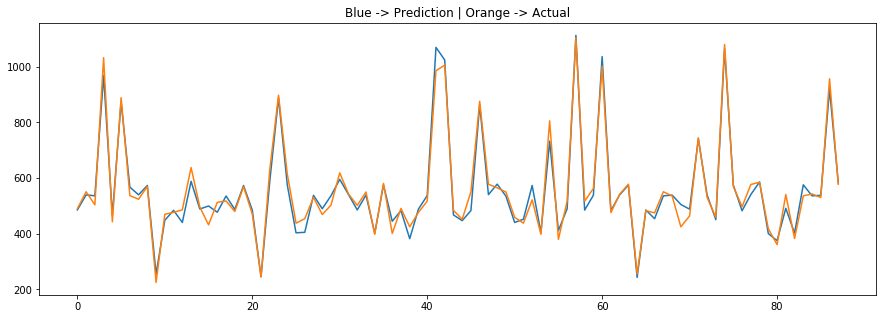

In [40]:
plt.figure(figsize=(15,5))
plt.plot(range(88), Y_pred_5)
plt.plot(range(88), y_test)
plt.title('Blue -> Prediction | Orange -> Actual')
plt.show()

Using the attribute 'feature_importances_' to rank the importance of each feature with respect to the target variable.

In [41]:
importance = rfregr.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfregr.estimators_],
             axis=0)
indices = np.argsort(importance)[::-1]

print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importance[indices[f]]))

Feature ranking:
1. feature 8 (0.136912)
2. feature 5 (0.132775)
3. feature 18 (0.111000)
4. feature 0 (0.108128)
5. feature 10 (0.095670)
6. feature 4 (0.093800)
7. feature 6 (0.085952)
8. feature 7 (0.081039)
9. feature 9 (0.056318)
10. feature 12 (0.056283)
11. feature 15 (0.014188)
12. feature 22 (0.004791)
13. feature 14 (0.004715)
14. feature 13 (0.003334)
15. feature 2 (0.002926)
16. feature 11 (0.002229)
17. feature 1 (0.002086)
18. feature 21 (0.002047)
19. feature 20 (0.001494)
20. feature 3 (0.001395)
21. feature 16 (0.000985)
22. feature 19 (0.000889)
23. feature 17 (0.000685)
24. feature 24 (0.000188)
25. feature 23 (0.000175)


## Gradient Boost Regressor

    Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. The objective of any supervised learning algorithm is to define a loss function and minimize it. Gradient Boosting allows for the optimization of arbitrary differentiable loss functions. In each stage a regression tree is fit on the negative gradient of the given loss function.

In [42]:
from sklearn.ensemble import GradientBoostingRegressor
gbregr = GradientBoostingRegressor(n_estimators=100, max_depth=6, verbose=True, random_state=1)
gbregr.fit(X_train, y_train)
gbrtrain = r2_score(y_train, gbregr.predict(X_train))
print("Random Forest Train data:", gbrtrain)

      Iter       Train Loss   Remaining Time 
         1       28977.1649            0.33s
         2       23555.3854            0.27s
         3       19160.8347            0.29s
         4       15592.9730            0.28s
         5       12702.6984            0.26s
         6       10360.6698            0.25s
         7        8457.8801            0.25s
         8        6908.6553            0.24s
         9        5644.6246            0.24s
        10        4617.9809            0.23s
        20         716.9405            0.19s
        30         175.5942            0.16s
        40          68.4614            0.14s
        50          35.9026            0.11s
        60          17.9462            0.09s
        70          12.7482            0.07s
        80          10.4450            0.05s
        90           8.3937            0.02s
       100           7.0558            0.00s
Random Forest Train data: 0.9998021779046163


In [43]:
Y_pred_6 = gbregr.predict(X_test)
GBRerror = r2_score(y_test, Y_pred_6)
print("Random Forest Test data:", GBRerror)

Random Forest Test data: 0.9792305265426914


Visualizing the predictions made by the Gradient Boosting Regressor and comparing it with the actual data points present in the training and testing dataset.

Text(0.5,1,'TRAIN DATA: Blue -> Prediction | Orange -> Actual')

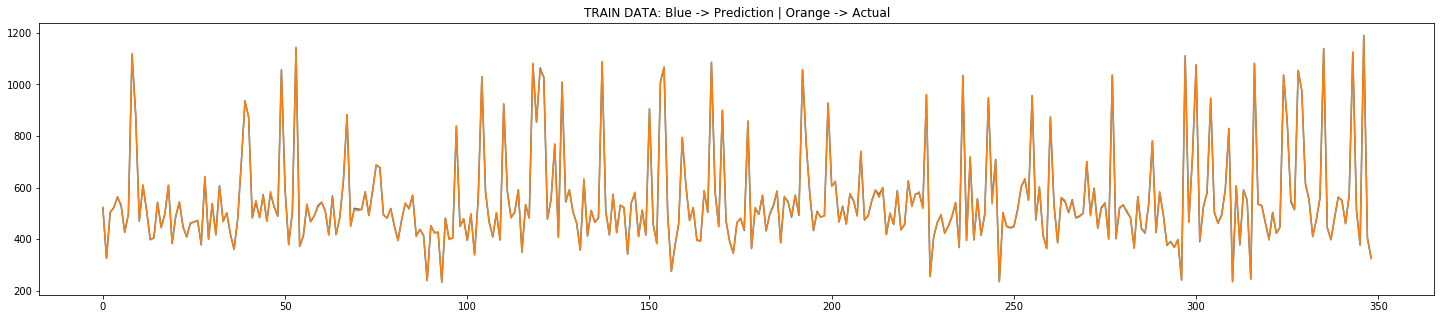

In [44]:
train_pred_6 = gbregr.predict(X_train)
plt.figure(figsize=(25,5))
plt.plot(range(349), train_pred_6)
plt.plot(range(349), y_train)
plt.title('TRAIN DATA: Blue -> Prediction | Orange -> Actual')

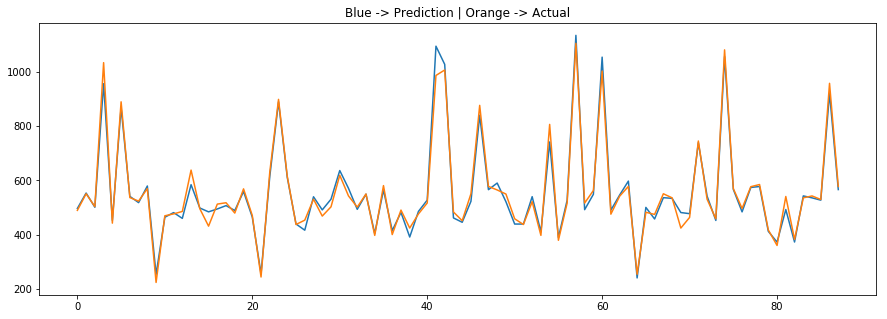

In [45]:
plt.figure(figsize=(15,5))
plt.plot(range(88), Y_pred_6)
plt.plot(range(88), y_test)
plt.title('Blue -> Prediction | Orange -> Actual')
plt.show()

## ADA Boost regressor

    An AdaBoost regressor is a meta-estimator that begins by fitting a regressor on the original dataset and then fits additional copies of the regressor on the same dataset but where the weights of instances are adjusted according to the error of the current prediction. As such, subsequent regressors focus more on difficult cases.

    AdaBoost can be used to boost the performance of any machine learning algorithm. These are models that achieve accuracy just above random chance on a classification problem. The most suited and therefore most common algorithm used with AdaBoost are decision trees with one level. Because these trees are so short and only contain one decision for classification, they are often called decision stumps.

In [46]:
from sklearn.ensemble import AdaBoostRegressor
adaregr = AdaBoostRegressor(n_estimators=100, learning_rate=2.0, random_state=1)
adaregr.fit(X_train, y_train)
adartrain = r2_score(y_train, adaregr.predict(X_train))
print("Random Forest Train data:", adartrain)

Random Forest Train data: 0.9757536661110687


In [47]:
Y_pred_7 = adaregr.predict(X_test)
adaRerror = r2_score(y_test, Y_pred_7)
print("Random Forest Test data:", adaRerror)

Random Forest Test data: 0.9714642305667481


Visualizing the predictions made by the ADA Boost Regressor and comparing it with the actual data points present in the training and testing dataset.

Text(0.5,1,'TRAIN DATA: Blue -> Prediction | Orange -> Actual')

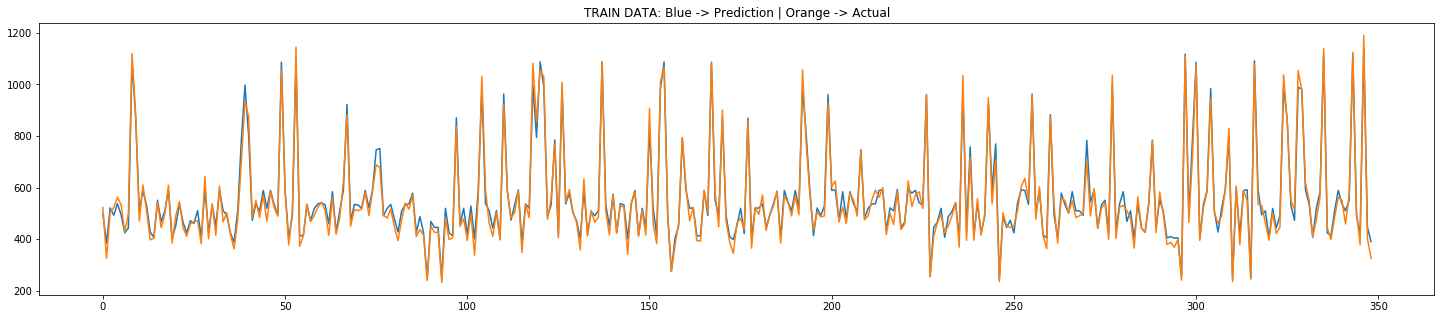

In [48]:
train_pred_7 = adaregr.predict(X_train)
plt.figure(figsize=(25,5))
plt.plot(range(349), train_pred_7)
plt.plot(range(349), y_train)
plt.title('TRAIN DATA: Blue -> Prediction | Orange -> Actual')

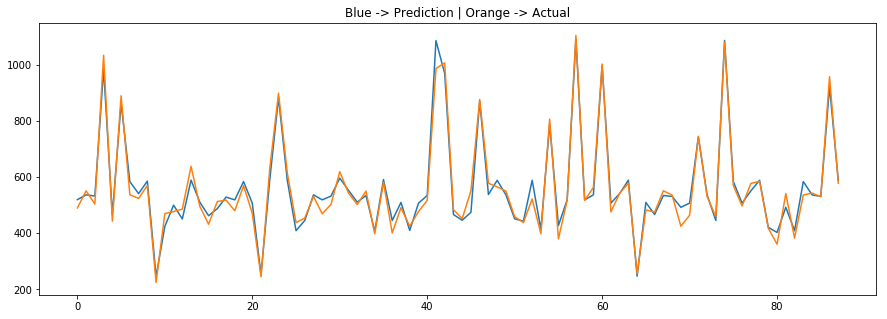

In [49]:
plt.figure(figsize=(15,5))
plt.plot(range(88), Y_pred_7)
plt.plot(range(88), y_test)
plt.title('Blue -> Prediction | Orange -> Actual')
plt.show()

In [71]:
importance_1 = adaregr.feature_importances_
std_1 = np.std([tree.feature_importances_ for tree in adaregr.estimators_],
             axis=0)
indices_1 = np.argsort(importance_1)[::-1]

print("Feature ranking:")

for f in range(independent_features.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices_1[f], importance_1[indices_1[f]]))

Feature ranking:
1. feature 9 (0.286250)
2. feature 18 (0.220727)
3. feature 5 (0.087561)
4. feature 12 (0.079360)
5. feature 10 (0.051163)
6. feature 0 (0.043103)
7. feature 6 (0.035909)
8. feature 4 (0.027385)
9. feature 13 (0.024522)
10. feature 7 (0.022742)
11. feature 16 (0.019761)
12. feature 21 (0.019292)
13. feature 20 (0.017060)
14. feature 22 (0.013345)
15. feature 14 (0.009467)
16. feature 11 (0.008975)
17. feature 15 (0.008586)
18. feature 1 (0.006744)
19. feature 8 (0.005007)
20. feature 19 (0.004392)
21. feature 2 (0.003408)
22. feature 17 (0.003360)
23. feature 3 (0.001542)
24. feature 23 (0.000340)
25. feature 24 (0.000000)


## LightGBM

    LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with faster training speed and higher efficiency, lower memory usage and better accuracy. It is based on decision tree algorithms and is used for ranking, classification, regression and many more maching learning tasks. 
    
    Light GBM grows tree vertically while other algorithm grows trees horizontally meaning that Light GBM grows tree leaf-wise while other algorithm grows level-wise. It will choose the leaf with max delta loss to grow. When growing the same leaf, Leaf-wise algorithm can reduce more loss than a level-wise algorithm.

In [50]:
import lightgbm as lgb
lgbmregr = lgb.LGBMRegressor(n_jobs=-1, verbose=1, subsample=1.0, min_split_gain=.01)
lgbmregr.fit(X_train, y_train)
lgbmrtrain = r2_score(y_train, lgbmregr.predict(X_train))
print("Random Forest Train data:", lgbmrtrain)

Random Forest Train data: 0.9928816751447077


In [51]:
Y_pred_8 = lgbmregr.predict(X_test)
lgbmRerror = r2_score(y_test, Y_pred_8)
print("Random Forest Test data:", lgbmRerror)

Random Forest Test data: 0.9806519818447144


Visualizing the predictions made by the LightGBM Regressor and comparing it with the actual data points present in the training and testing dataset.

Text(0.5,1,'TRAIN DATA: Blue -> Prediction | Orange -> Actual')

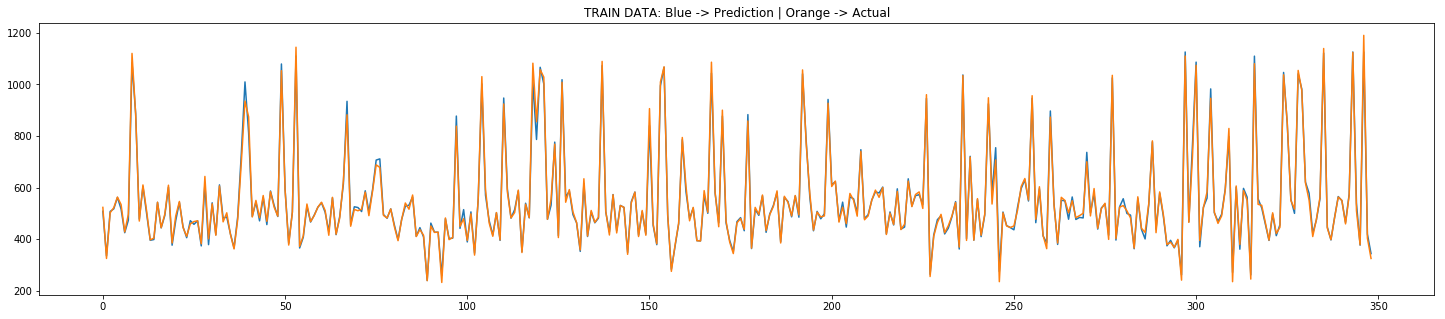

In [52]:
train_pred_8 = lgbmregr.predict(X_train)
plt.figure(figsize=(25,5))
plt.plot(range(349), train_pred_8)
plt.plot(range(349), y_train)
plt.title('TRAIN DATA: Blue -> Prediction | Orange -> Actual')

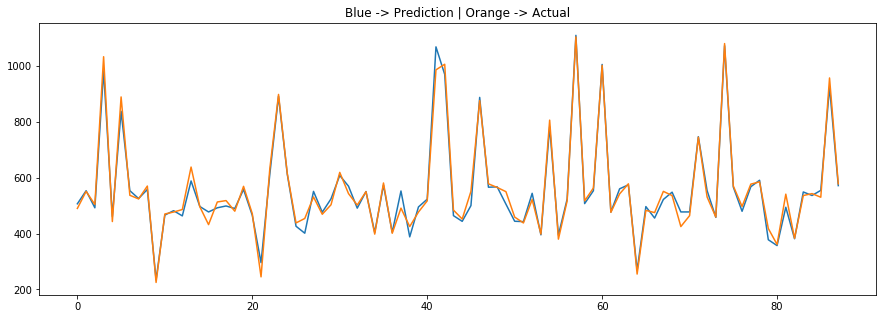

In [53]:
plt.figure(figsize=(15,5))
plt.plot(range(88), Y_pred_8)
plt.plot(range(88), y_test)
plt.title('Blue -> Prediction | Orange -> Actual')
plt.show()

Using the attribute 'feature_importances_' to rank the importance of each feature with respect to the target variable.

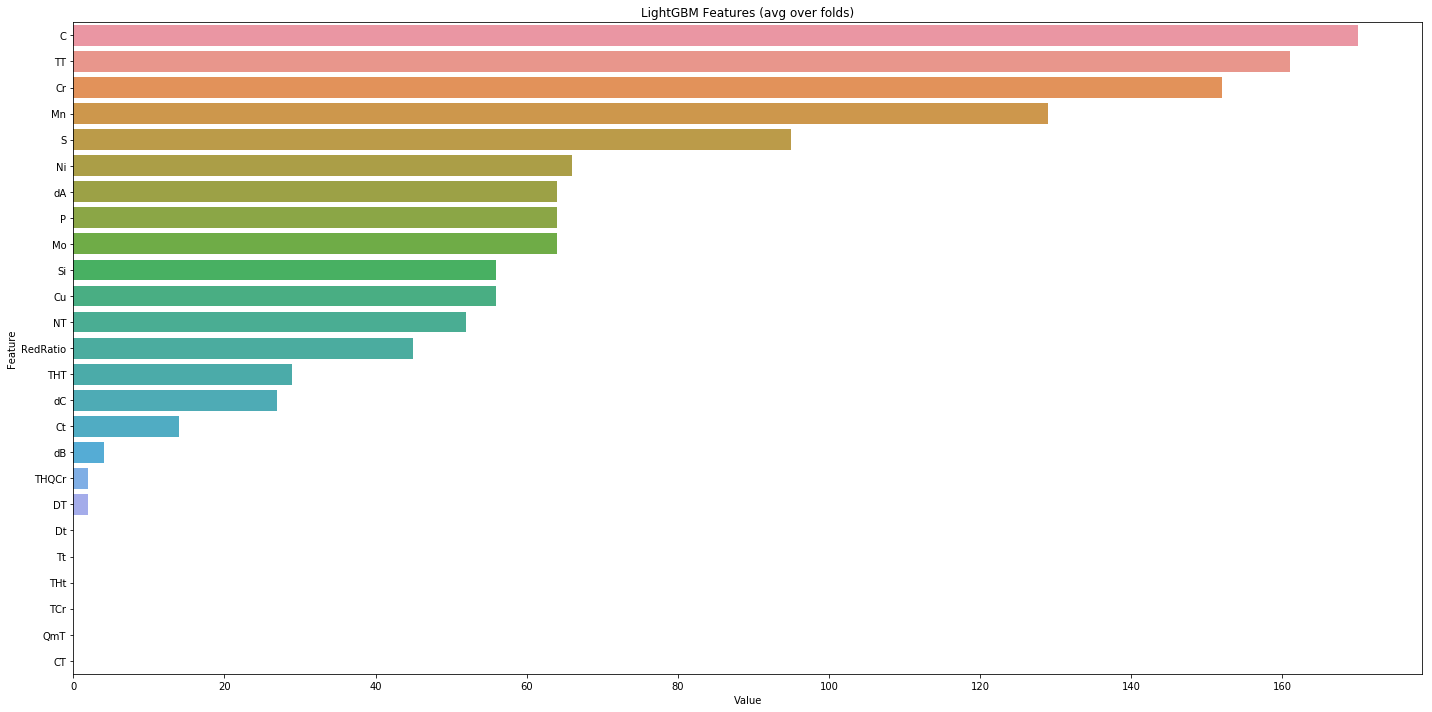

<Figure size 432x288 with 0 Axes>

In [55]:
import seaborn as sns

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(lgbmregr.feature_importances_,independent_features.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

## XGBoost Regressor

    XGBoost stands for “Extreme Gradient Boosting”, where the term “Gradient Boosting” originates from the paper Greedy Function Approximation: A Gradient Boosting Machine, by Friedman. XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples.

In [56]:
xgbregr = xgb.XGBRegressor(n_estimators=100, learning_rate=0.15, max_depth=4)
xgbregr.fit(X_train, y_train)
XGBtrain = r2_score(y_train, xgbregr.predict(X_train))
print("XGBoost Regressor Train data:", XGBtrain)

XGBoost Regressor Train data: 0.9977835538741837


In [57]:
Y_pred_9 = xgbregr.predict(X_test)
XGBerror = r2_score(y_test, Y_pred_9)
print("XGBoost Regressor Test data:", XGBerror)

XGBoost Regressor Test data: 0.9822711012893626


Visualizing the predictions made by the XGBoost Regressor and comparing it with the actual data points present in the training and testing dataset.

Text(0.5,1,'TRAIN DATA: Blue -> Prediction | Orange -> Actual')

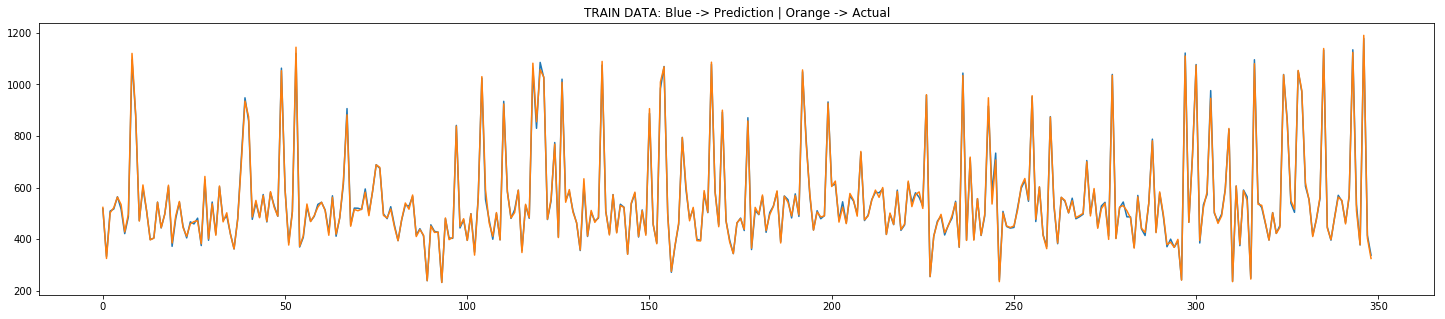

In [58]:
train_pred_9 = xgbregr.predict(X_train)
plt.figure(figsize=(25,5))
plt.plot(range(349), train_pred_9)
plt.plot(range(349), y_train)
plt.title('TRAIN DATA: Blue -> Prediction | Orange -> Actual')

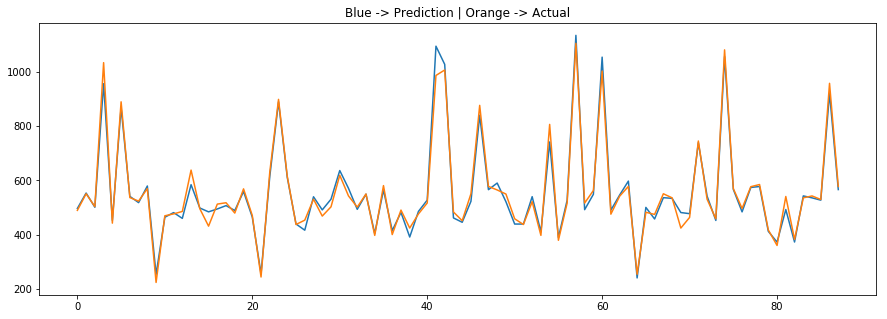

In [59]:
plt.figure(figsize=(15,5))
plt.plot(range(88), Y_pred_6)
plt.plot(range(88), y_test)
plt.title('Blue -> Prediction | Orange -> Actual')
plt.show()

<Figure size 720x360 with 0 Axes>

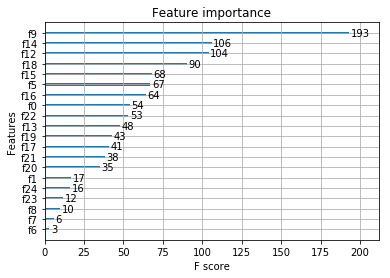

In [70]:
from xgboost import plot_importance
plot_importance(xgbregr)
plt.show()